In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
random_state=0

In [2]:
data= pd.read_csv('auto-mpg.csv')

In [3]:
data.head()

,mpg,cylinders,displacement,hp,weight,acc,year,carname
0,18.0,8,307.0,130,3504,12.0,70,"1\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165,3693,11.5,70,"1\t""buick skylark 320"""
2,18.0,8,318.0,150,3436,11.0,70,"1\t""plymouth satellite"""
3,16.0,8,304.0,150,3433,12.0,70,"1\t""amc rebel sst"""
4,17.0,8,302.0,140,3449,10.5,70,"1\t""ford torino"""


In [4]:
# convert a feature to categorical
data['carname'] = data['carname'].astype('category')
data["carname"] = data["carname"].cat.codes

In [5]:
# separate the features and the target variable
X = data.iloc[:, 1:] 
y = data.iloc[:, 0] 

# calculate the correlation matrix
corr_matrix = X.corrwith(y)

# sort the features by correlation with the target variable
sorted_features = corr_matrix.abs().sort_values(ascending=False)

# select the top k features
k = 5
selected_features = sorted_features[:k].index.tolist()

# create a new dataframe with the selected features and the target variable
df = data[[y.name] + selected_features]

# separate the selected features and the target variable
X = df.iloc[:, 1:] 
y = df.iloc[:, 0] 


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.20,random_state=0)
ranf = RandomForestRegressor(random_state=0)
rf= ranf.fit(X_train,y_train)
scores_rf= cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores_rf
print(np.mean(scores_rf))

y_pred_rf = cross_val_predict(ranf, X_test,y_test)
scores_test_rf= cross_val_score(ranf, X_test, y_test,scoring='neg_mean_squared_error',cv=10)
print(np.mean(scores_test_rf))

-8.420076206021637
-7.556425249999998


In [7]:
def impute_missing_values(X_train, X_test, y_train, kappa=6):
    y_train_np = y_train.to_numpy()
    mean_values = X_train.apply(lambda col: y_train.groupby(X_train[col.name]).mean())

    unique_values = {col: X_train[col].unique() for col in X_train.columns}
    imputed_values_train = {}
    imputed_values_test = {}

    for col in X_train.columns:
        imputed_values_train[col] = {val: mean_values[col][val] for val in unique_values[col]}
        imputed_values_test[col] = {val: mean_values[col][val] for val in unique_values[col] if val in X_test[col].unique()}

        extra_values = set(X_test[col].unique()) - set(unique_values[col])
        if extra_values:
            
            # print(f"Warning: There are values in column '{col}' of X_test that are not present in X_train.")

            X_train_imputed = X_train.copy()
            X_test_imputed = X_test.copy()

    for col in X_train.columns:
        X_train_imputed[col] = X_train[col].map(imputed_values_train[col])

    for col in X_test.columns:
        X_test_imputed[col] = X_test[col].apply(lambda x: imputed_values_test[col].get(x, np.nan))

    for col in X_test_imputed.columns:
        missing_indices = X_test_imputed[X_test_imputed[col].isna()].index

        if len(missing_indices) > 0:
            d = np.linalg.norm(X_test.loc[missing_indices].values[:, np.newaxis] - X_train.values, axis=2)

            for i, idx in enumerate(missing_indices):
                l = 0
                v = 0
                for j in range(len(y_train)):
                    l += y_train_np[j] / ((1 + d[i, j]) ** kappa)
                    v += 1 / ((1 + d[i, j]) ** kappa)
                imputed_value = l / v
                X_test_imputed.at[idx, col] = imputed_value

    return X_train_imputed, X_test_imputed


In [8]:
def prop_reg(X_test,X_train,y_train,y_test,kappa):
    d = np.zeros((len(X_test),len(X_train)))
    for i in range(len(X_test)):
        for j in range(len(X_train)):
            d[i,j] = np.linalg.norm(X_test[i]-X_train[j])
    c=np.zeros(len(y_test))
    for i in range(len(y_test)):
        l=0
        v=0
        for j in range(len(y_train)):
            
            l+=y_train[j]/((1+d[i,j])**kappa)
            v+=1/((1+d[i,j])**kappa)
        
        c[i]=l/v
    return(c)

kappa = 1, avg MSE = 34.778
kappa = 2, avg MSE = 19.147
kappa = 3, avg MSE = 16.013
kappa = 4, avg MSE = 15.911
kappa = 5, avg MSE = 16.439
kappa = 6, avg MSE = 16.903
kappa = 7, avg MSE = 17.353
kappa = 8, avg MSE = 17.774
kappa = 9, avg MSE = 18.164


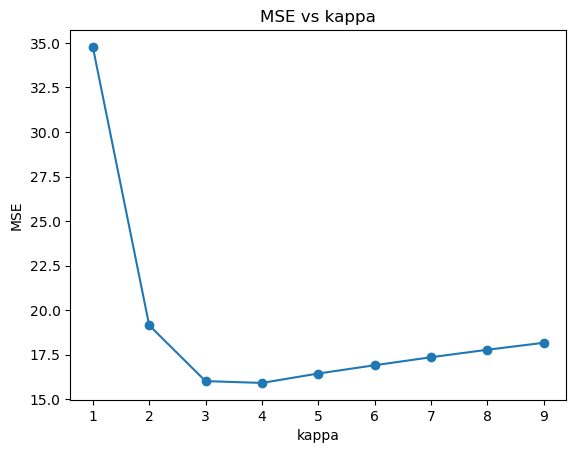

In [9]:


def impute_and_predict(X, y, kappa):
    kf = KFold(n_splits=10)
    mse_values = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train_imputed, X_test_imputed = impute_missing_values(X_train, X_test, y_train, kappa)
        
        y_pred = prop_reg(X_test_imputed.values, X_train_imputed.values, y_train.values, y_test.values, kappa)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)
    
    avg_mse = np.mean(mse_values)
    
    return avg_mse

kappa_values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
mse_values = []

for kappa in kappa_values:
    mse = impute_and_predict(X, y, kappa)
    mse_values.append(mse)
    print(f"kappa = {kappa}, avg MSE = {mse:.3f}")

plt.plot(kappa_values, mse_values, '-o')
plt.xlabel('kappa')
plt.ylabel('MSE')
plt.title('MSE vs kappa')
plt.show()


In [10]:
# find the index of the minimum MSE value
min_index = np.argmin(mse_values)

# print the minimum MSE value and the corresponding kappa value
print(f"Minimum MSE: {mse_values[min_index]:.3f}, Kappa value: {kappa_values[min_index]}")


Minimum MSE: 15.911, Kappa value: 4
